In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

mpl.rcParams['font.size'] = 18.0
mpl.rcParams['xtick.labelsize'] = 18.0
mpl.rcParams['ytick.labelsize'] = 18.0
mpl.rcParams['axes.labelsize'] = 18.0
mpl.rcParams['axes.labelsize'] = 18.0

import copy
from hendrics.fake import filter_for_deadtime
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum


import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack

from stingray.utils import rebin_data

np.random.seed(348172694)

from stingray import Lightcurve, Crossspectrum
from stingray.simulator.simulator import Simulator
from scipy.ndimage.filters import gaussian_filter1d


np.random.seed(1209432)

# Dead time - white noise case
Here we show that the difference of Fourier amplitudes is _not_ independent of frequency when dead time is presence, but still _independent from the intrinsic stochastic noise of the source_. Therefore, this dependence is **exactly the same that we want to eliminate from the Power spectrum, but in this case it is not affected by the signal.**

We start by simulating uniformly distributed events, to mimick a constant-flux light curve, and applying a dead time filter.

In [2]:

length = 1000
whitenoise_ev_1 = np.sort(np.random.uniform(0, length, 2000000))
whitenoise_ev_2 = np.sort(np.random.uniform(0, length, 2000000))

lc1 = Lightcurve.make_lightcurve(whitenoise_ev_1, gti=[[0, length]], tstart=0, tseg=length, dt=1/4096)
lc2 = Lightcurve.make_lightcurve(whitenoise_ev_2, gti=[[0, length]], tstart=0, tseg=length, dt=1/4096)

# plt.figure(figsize=(10, 5))

lc1_rough = Lightcurve.make_lightcurve(whitenoise_ev_1, gti=[[0, length]], tstart=0, tseg=length, dt=0.3)
# plt.plot(lc1_rough.time, lc1_rough.counts, lw=1, color='k', label='No dead time')

cs = Crossspectrum(lc1, lc2, norm="leahy")
pds = Powerspectrum(lc1, norm="leahy")

wn_ev_1_dt = filter_for_deadtime(whitenoise_ev_1, 2.5e-3)
wn_ev_2_dt = filter_for_deadtime(whitenoise_ev_2, 2.5e-3)

lc1 = Lightcurve.make_lightcurve(wn_ev_1_dt, gti=[[0, length]], tstart=0, tseg=length, dt=1/4096)
lc2 = Lightcurve.make_lightcurve(wn_ev_2_dt, gti=[[0, length]], tstart=0, tseg=length, dt=1/4096)

lc1_rough = Lightcurve.make_lightcurve(wn_ev_1_dt, gti=[[0, length]], tstart=0, tseg=length, dt=0.3)


and we plot the clean and deadtime-affected periodograms

In [3]:
cs_dt = Crossspectrum(lc1, lc2, norm="leahy")
pds1_dt = Powerspectrum(lc1, norm="leahy")
pds2_dt = Powerspectrum(lc2, norm="leahy")
pds_dt = copy.copy(pds1_dt)
pds_dt.m = 2 * pds_dt.m
pds_dt.power = (pds1_dt.power + pds2_dt.power) / 2

fig, ax1 = plt.subplots(1, 1, figsize=(10,7))
ax1.plot(pds1_dt.freq, pds1_dt.power, color='r', alpha=0.5, lw=1, label='Power density spectrum, with dead time')
ax1.plot(pds.freq, pds.power, color='k', alpha=0.5, lw=1, label='Power density spectrum, no dead time')

ax1.legend()
ax1.set_ylabel('Power (Leahy)')

ax1.set_xlabel('Frequency (Hz)')
ax1.set_xlim([0, 2048])
ax1.set_ylim([0, None])
plt.savefig('pds_dt.jpg')

<IPython.core.display.Javascript object>

Now, we do the same as in notebook 1, and calculate the Fourier amplitude differences in the case of dead time.

In [4]:
plt.figure(figsize=(3.3, 7))
# plt.suptitle("Red noise, no dead time")
gs = GridSpec(2, 1, hspace=0)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

fourier_all = []
diff_all = []
for start_time in np.arange(lc1.time[0], lc1.time[-1], 2):
    good = (lc1.time > start_time)&(lc1.time < start_time + 2)
    good_counts1 = lc1.counts[good]
    good_counts2 = lc2.counts[good]
    
    fourier1 = scipy.fftpack.fft(good_counts1)
    fourier2 = scipy.fftpack.fft(good_counts2)

    freqs = scipy.fftpack.fftfreq(len(good_counts1), lc1.dt)

    fourier1 = fourier1[freqs>0] * np.sqrt(2 / np.sum(good_counts1))
    fourier2 = fourier2[freqs>0] * np.sqrt(2 / np.sum(good_counts2))
    freqs = freqs[freqs > 0]

    ax0.plot(freqs, fourier1.real, drawstyle='steps-mid', color='k', alpha=0.5, lw=0.5)
#     ax0.plot(freqs, fourier2.real, drawstyle='steps-mid', color='r', alpha=0.5, lw=0.5)
#     ax0.plot(freqs, gaussian_filter1d(np.sqrt(fourier2 * fourier1.conj()).real, 10), lw=1)
    ax0.semilogx()
    fourier_all.append(fourier1.real)
    
    ax1.plot(freqs, (fourier1 - fourier2).real, drawstyle='steps-mid', color='k', alpha=0.5, lw=0.5)
    diff_all.append((fourier1 - fourier2).real)

fourier_all = np.array(fourier_all)
diff_all = np.array(diff_all)

ax0.plot(freqs, gaussian_filter1d(np.mean(np.abs(fourier_all), axis=0), 1), lw=2, color='r')
ax0.plot(freqs, -gaussian_filter1d(np.mean(np.abs(fourier_all), axis=0), 1),  lw=2, color='r')
# ax0.set_ylabel('Fourier amplitudes')

ax1.plot(freqs, gaussian_filter1d(np.mean(np.abs(diff_all), axis=0), 10), lw=2, color='r')
ax1.plot(freqs, -gaussian_filter1d(np.mean(np.abs(diff_all), axis=0), 10), lw=2, color='r')
# ax1.set_ylabel('$\mathcal{F}_1 - \mathcal{F}_2$')
plt.setp(ax0.get_xticklabels(), visible=False)

ax1.set_xlabel('Frequency (Hz)')
ax0.set_xlim(freqs[0], freqs[-1])
plt.tight_layout()

plt.savefig('wn_fourierdiff.eps')


<IPython.core.display.Javascript object>

Below, we take the average of the absolute value of the Fourier amplitudes and Fourier amplitude differences in each bin, plot them against each other, and fit their correlation.
The correlation turns out to be 0.707, or $1/\sqrt{2}$

In [5]:
from scipy.optimize import curve_fit

def slope(x, a=1):
    return a*x

plt.figure(figsize=(3.3, 7))

diff = np.mean(np.abs(diff_all.real), axis=0)
four = np.mean(np.abs(fourier_all.real), axis=0)
plt.scatter(diff, four, s=1, c='k')

par, pcov = curve_fit(slope, diff, four)
xplot = np.linspace(0, np.max(diff), 1000)
# plt.plot(xplot, slope(xplot, *par), 'k--', label=r'Best fit: $y = {:.3f} x$'.format(par[0]))
plt.plot(xplot, slope(xplot, 2**(-0.5)), 'r--', label=r'$y = x/\sqrt{2}$')
print('The slope is {:.3f}'.format(par[0]))

plt.ylabel(r'$|\mathcal{F}_1|$')
plt.xlabel(r'$\left| \mathcal{F}_1 - \mathcal{F}_2 \right|$')

plt.legend()

plt.xlim([0, None])
plt.ylim([0, None])
# plt.title('PDS 1 vs Frequency Amplitude Difference')
plt.tight_layout()
plt.savefig('fourier_vs_diff_dt.eps')

<IPython.core.display.Javascript object>

The slope is 0.707


We can do an analogous procedure with the periodogram

In [6]:
plt.figure(figsize=(10, 7))
# plt.suptitle("White noise, Dead time 2.5 ms")
gs = GridSpec(2, 1, hspace=0)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
# ax2 = plt.subplot(gs[2], sharex=ax0)

fourier_all = []
cospec_all = []
diff_all = []
start_times = np.arange(lc1.time[0], lc1.time[-1], 2)
for start_time in start_times:
    good = (lc1.time >= start_time)&(lc1.time < start_time + 2)
    good_counts1 = lc1.counts[good]
    good_counts2 = lc2.counts[good]
    
    fourier1 = scipy.fftpack.fft(good_counts1)
    fourier2 = scipy.fftpack.fft(good_counts2)

    freqs = scipy.fftpack.fftfreq(len(good_counts1), lc1.dt)

    fourier1 = fourier1[freqs>0] * np.sqrt(2 / np.sum(good_counts1))
    fourier2 = fourier2[freqs>0] * np.sqrt(2 / np.sum(good_counts2))
    freqs = freqs[freqs > 0]

    ax0.plot(freqs, (fourier1 * fourier2.conj()).real, drawstyle='steps-mid', color='k', alpha=0.5, lw=0.5)
    ax0.semilogx()
    cospec_all.append((fourier1 * fourier2.conj()).real)
    fourier_all.append((fourier1 * fourier1.conj()).real)
    
    ax1.plot(freqs, (fourier1 - fourier2).real, drawstyle='steps-mid', color='k', alpha=0.5, lw=0.5)
    diff_all.append((fourier1 - fourier2).real)
    
cospec_all = np.array(cospec_all)
fourier_all = np.array(fourier_all)
diff_all = np.array(diff_all)

ax0.plot(freqs, gaussian_filter1d(np.std((fourier_all.real), axis=0), 10), lw=2, color='r')
ax0.plot(freqs, -gaussian_filter1d(np.std((fourier_all.real), axis=0), 10),  lw=2, color='r')
ax0.set_ylabel(r'$\mathcal{P}_1$')

ax1.plot(freqs, gaussian_filter1d(np.mean(np.abs(diff_all.real), axis=0), 10), lw=2, color='r')
ax1.plot(freqs, -gaussian_filter1d(np.mean(np.abs(diff_all.real), axis=0), 10), lw=2, color='r')
ax1.set_ylabel(r'$\mathcal{F}_1 - \mathcal{F}_2$')

ax1.set_xlabel('Frequency (Hz)')
ax0.set_xlim(freqs[0], freqs[-1])

# ax2.plot(freqs, 
#          (fourier1 * fourier2.conj()).real / gaussian_filter1d(np.mean(np.abs(diff_all.real), axis=0), 10)**2,
#          color='k')
# ax2.set_ylabel(r'$\frac{\mathcal{C}}{\mathrm{smooth}(|\mathcal{F}_1 - \mathcal{F}_2|^2)}$')

# ax2.axhline(1, color='r')
# ax2.axhline(-1, color='r')

plt.savefig('wn_fourierdiff_dt.eps')


<IPython.core.display.Javascript object>

In [7]:
diff = np.mean(np.abs(diff_all.real)**2, axis=0)
four = np.mean(fourier_all.real, axis=0)
cosp = np.mean(np.array(cospec_all).real, axis=0)

In [8]:
from scipy.optimize import curve_fit

def slope(x, a=1):
    return a*x

plt.figure(figsize=(10, 7))

plt.scatter(diff, four, s=1, c='k')

par, pcov = curve_fit(slope, diff, four)
xplot = np.linspace(0, np.max(diff), 1000)
plt.plot(xplot, slope(xplot, *par), 'k--', label=r'Best fit: $y = {:.3f} x$'.format(par[0]))
plt.plot(xplot, slope(xplot, 1), 'r--', label=r'$y = x$'.format(par[0]))

plt.ylabel(r'Power (Leahy)')
plt.xlabel(r'$\left| \mathcal{F}_1 - \mathcal{F}_2 \right|^2$')

plt.legend()

plt.xlim([0, None])
plt.ylim([0, None])
# plt.title('PDS 1 vs Frequency Amplitude Difference')
plt.tight_layout()
plt.savefig('pds1_vs_diff_dt.eps')

<IPython.core.display.Javascript object>

Now, let's try to use this correlation to correct the periodogram and the cospectrum!

In [9]:
plt.figure(figsize=(10, 5))

plt.plot(freqs, four,  c='grey', alpha=0.8, label=r'$\mathcal{P}_1}$')
plt.plot(freqs, four / diff * 2, c='k', label=r'$\mathrm{FAD}(\mathcal{P}_1)$')

plt.plot(freqs, cosp,  c='pink', alpha=0.8, label=r'$\mathcal{C}}$')
plt.plot(freqs, cosp / diff * 2,  c='r', alpha=0.8, label=r'$\mathrm{FAD}(\mathcal{C})$')

plt.ylabel('Power (Leahy)')
plt.xlabel(r'$\nu$ (Hz)')
plt.xlim([0, 2048])
# plt.ylim()
plt.legend()
plt.tight_layout()
plt.savefig('before_and_after.eps')

<IPython.core.display.Javascript object>

It **WORKS**!

In [ ]:
diff = np.mean(np.abs(diff_all.real)**2, axis=0)
four = np.mean(np.array(cospec_all).real, axis=0)
plt.figure(figsize=(10, 7))

plt.plot(freqs, 2 * four / diff, c='k', label='after FAD')
plt.plot(freqs, four, c='grey', alpha=0.8, label='before FAD')
plt.ylabel(r'$2\frac{\mathcal{C}}{\left| \mathcal{F}_1 - \mathcal{F}_2 \right|^2}$')
plt.xlabel(r'$\nu$ (Hz)')
plt.legend()

<IPython.core.display.Javascript object>

## Let's test if the distributions make sense after the correction

In [ ]:
from matplotlib.gridspec import GridSpec

plt.figure(figsize=(10, 8))
plt.title("Dead time")
gs = GridSpec(5, 1, hspace=0)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax2 = plt.subplot(gs[2], sharex=ax0)
ax3 = plt.subplot(gs[3], sharex=ax0)
ax4 = plt.subplot(gs[4], sharex=ax0)

hist_cosp = 0
hist_cosp_dt = 0
hist_pds = 0
hist_pds_dt = 0

count = 0
bins_cosp = np.arange(-50, 50, 0.01)
bins_pds = np.arange(-10, 100, 0.01)

for start_time in np.arange(lc1.tstart, lc1.tseg, 5):
    good = (lc1.time > start_time)&(lc1.time < start_time + 5)
    good_counts1 = lc1.counts[good]
    good_counts2 = lc2.counts[good]

    fourier1 = scipy.fftpack.fft(good_counts1)
    fourier2 = scipy.fftpack.fft(good_counts2)

    freqs = scipy.fftpack.fftfreq(len(good_counts1), lc1.dt)

    fourier1 = fourier1[freqs>0] * np.sqrt(2 / np.sum(good_counts1))
    fourier2 = fourier2[freqs>0] * np.sqrt(2 / np.sum(good_counts2))

    freqs = freqs[freqs > 0]

    smooth_real = gaussian_filter1d(((fourier1 - fourier2)).real**2, 50)

    # First panel: Amplitudes
    ax0.set_ylabel('Fourier Amps')
    ax0.scatter(freqs, fourier1.real, s=1, c='grey')
    ax0.scatter(freqs, fourier2.real, s=1, c='grey')
    ax0.plot(freqs, smooth_real, lw=1, color='red')

    # Second panel: Difference amplitudes
    ax1.set_ylabel('Diff. Fourier Amps')

    ax1.scatter(freqs, (fourier1 - fourier2).real, s=1, c='grey')
    ax1.plot(freqs, smooth_real, lw=1, color='red')

    # Third panel: Normalized amplitudes
    ax2.set_ylabel('Norm. Fourier Amps')
    ax2.scatter(freqs, fourier1.real / smooth_real ** 0.5, s=1, c='grey')

    # Fourth panel: Unnormalized cospectrum
    ax3.set_ylabel('Cospectrum')

    ax3.plot(freqs, (fourier1 * fourier2.conj()).real, drawstyle='steps-mid', 
             label='Unnormalized', lw=1, zorder= 10, color='grey')
    ax3.plot(freqs, smooth_real, lw=1, color='red', zorder=10)


    # Fifth panel: Normalized cospectrum
    ax4.set_ylabel('Norm. Cospectrum')

    ax4.plot(freqs, (fourier1 * fourier2.conj()).real / smooth_real * 2 ** 0.5, drawstyle='steps-mid', 
             label='Ratio by smoothed difference', lw=1, zorder= 10, color='grey')


    ax4.set_ylim([-20, 20])
    ax4.set_xlabel('Frequency (Hz)')
#     plt.legend()
    hist_cosp += np.histogram((fourier1 * fourier2.conj()).real / smooth_real * 2, 
                         bins=bins_cosp, normed=True)[0]
    hist_cosp_dt += np.histogram((fourier1 * fourier2.conj()).real, 
                         bins=bins_cosp, normed=True)[0]

    hist_pds += np.histogram((fourier1 * fourier1.conj()) / smooth_real * 2, 
                         bins=bins_pds, normed=True)[0]
    hist_pds_dt += np.histogram((fourier1 * fourier1.conj()), 
                                bins=bins_pds, normed=True)[0]



    count += 1

hist_cosp = hist_cosp / count
hist_cosp_dt = hist_cosp_dt / count

hist_pds = hist_pds / count
hist_pds_dt = hist_pds_dt / count

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


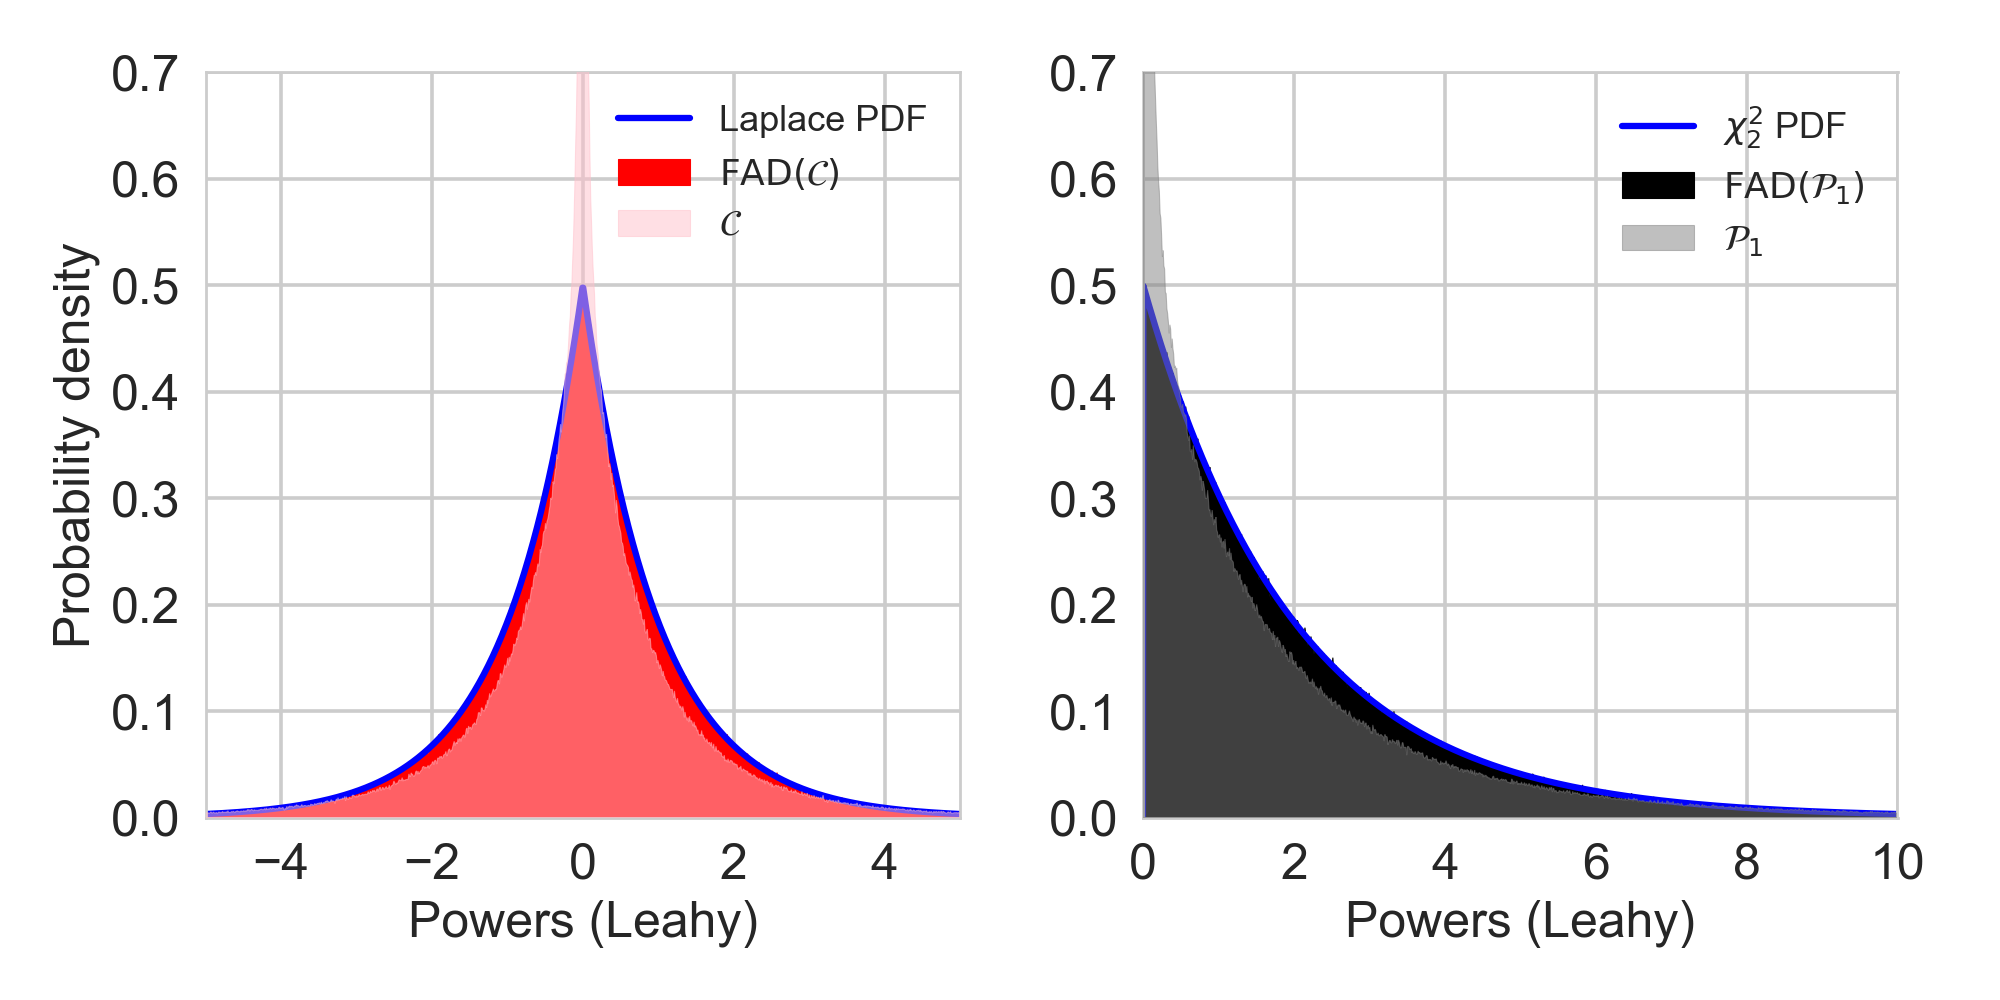

In [14]:
plt.figure(figsize=(10, 5))

gs = GridSpec(1, 2)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharey=ax0)
u = np.linspace(-50, 50, 10000)

lapl = scipy.stats.laplace(0, 1)
lapl_prob = lapl.pdf(u)

# plt.figure()

ax0.fill(bins_cosp[:-1] + 0.005, hist_cosp, label=r'$\mathrm{FAD}(\mathcal{C})$', color='r')
ax0.fill(bins_cosp[:-1] + 0.005, hist_cosp_dt, alpha=0.5, label=r'$\mathcal{C}$', color='pink', zorder=3)

ax0.plot(u, lapl_prob, label='Laplace PDF', color='b')
ax0.set_xlim([-5, 5])
ax0.set_ylim([0, 0.7])
ax0.legend()
ax0.set_xlabel('Powers (Leahy)')
ax0.set_ylabel('Probability density')

# plt.savefig('cosp_pdf.eps')

# plt.figure()
u = np.linspace(-10, 50, 10000)
chisq = scipy.stats.chi2(2)
chisq_prob = chisq.pdf(u)


ax1.fill(bins_pds[:-1] + 0.005, hist_pds, label=r'$\mathrm{FAD}(\mathcal{P}_1)$', color='k')
ax1.fill(bins_pds[:-1] + 0.005, hist_pds_dt, alpha=0.5, label=r'$\mathcal{P}_1$', color='grey', zorder=3)


ax1.plot(u, chisq_prob, label='$\chi^2_2$ PDF', color='b')
ax1.set_xlabel('Powers (Leahy)')
# ax1.set_ylabel('Probability density')

ax1.legend()
ax1.set_xlim([0, 10])
ax1.set_ylim([0, 0.7])
plt.tight_layout()

plt.savefig('pds_pdf.pdf')

<IPython.core.display.Javascript object>


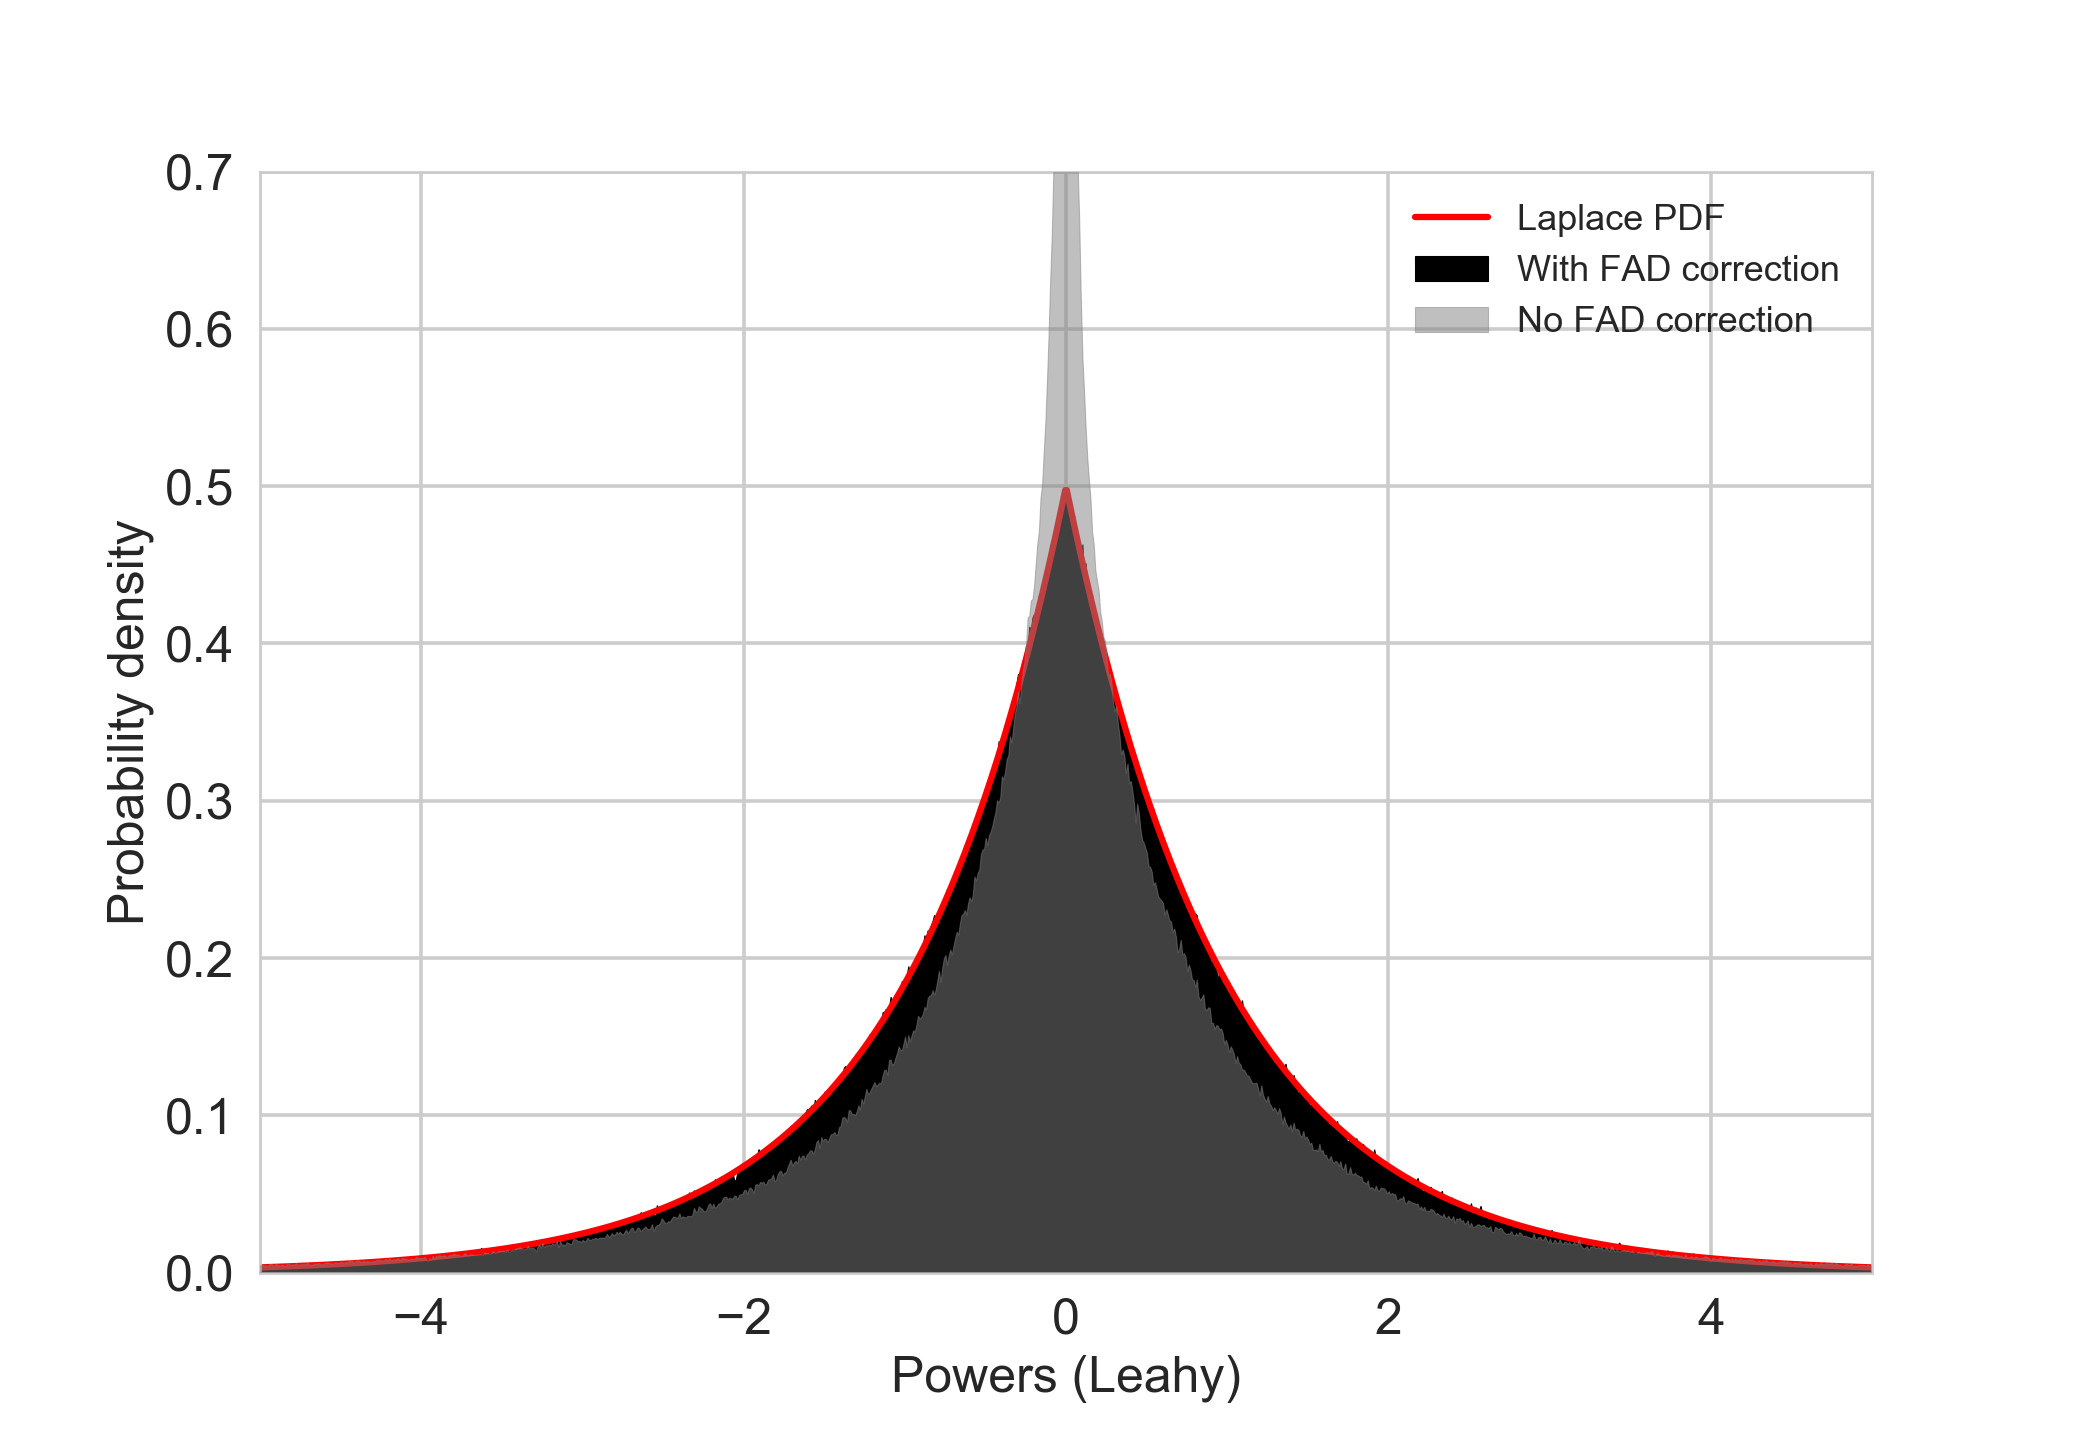

<IPython.core.display.Javascript object>


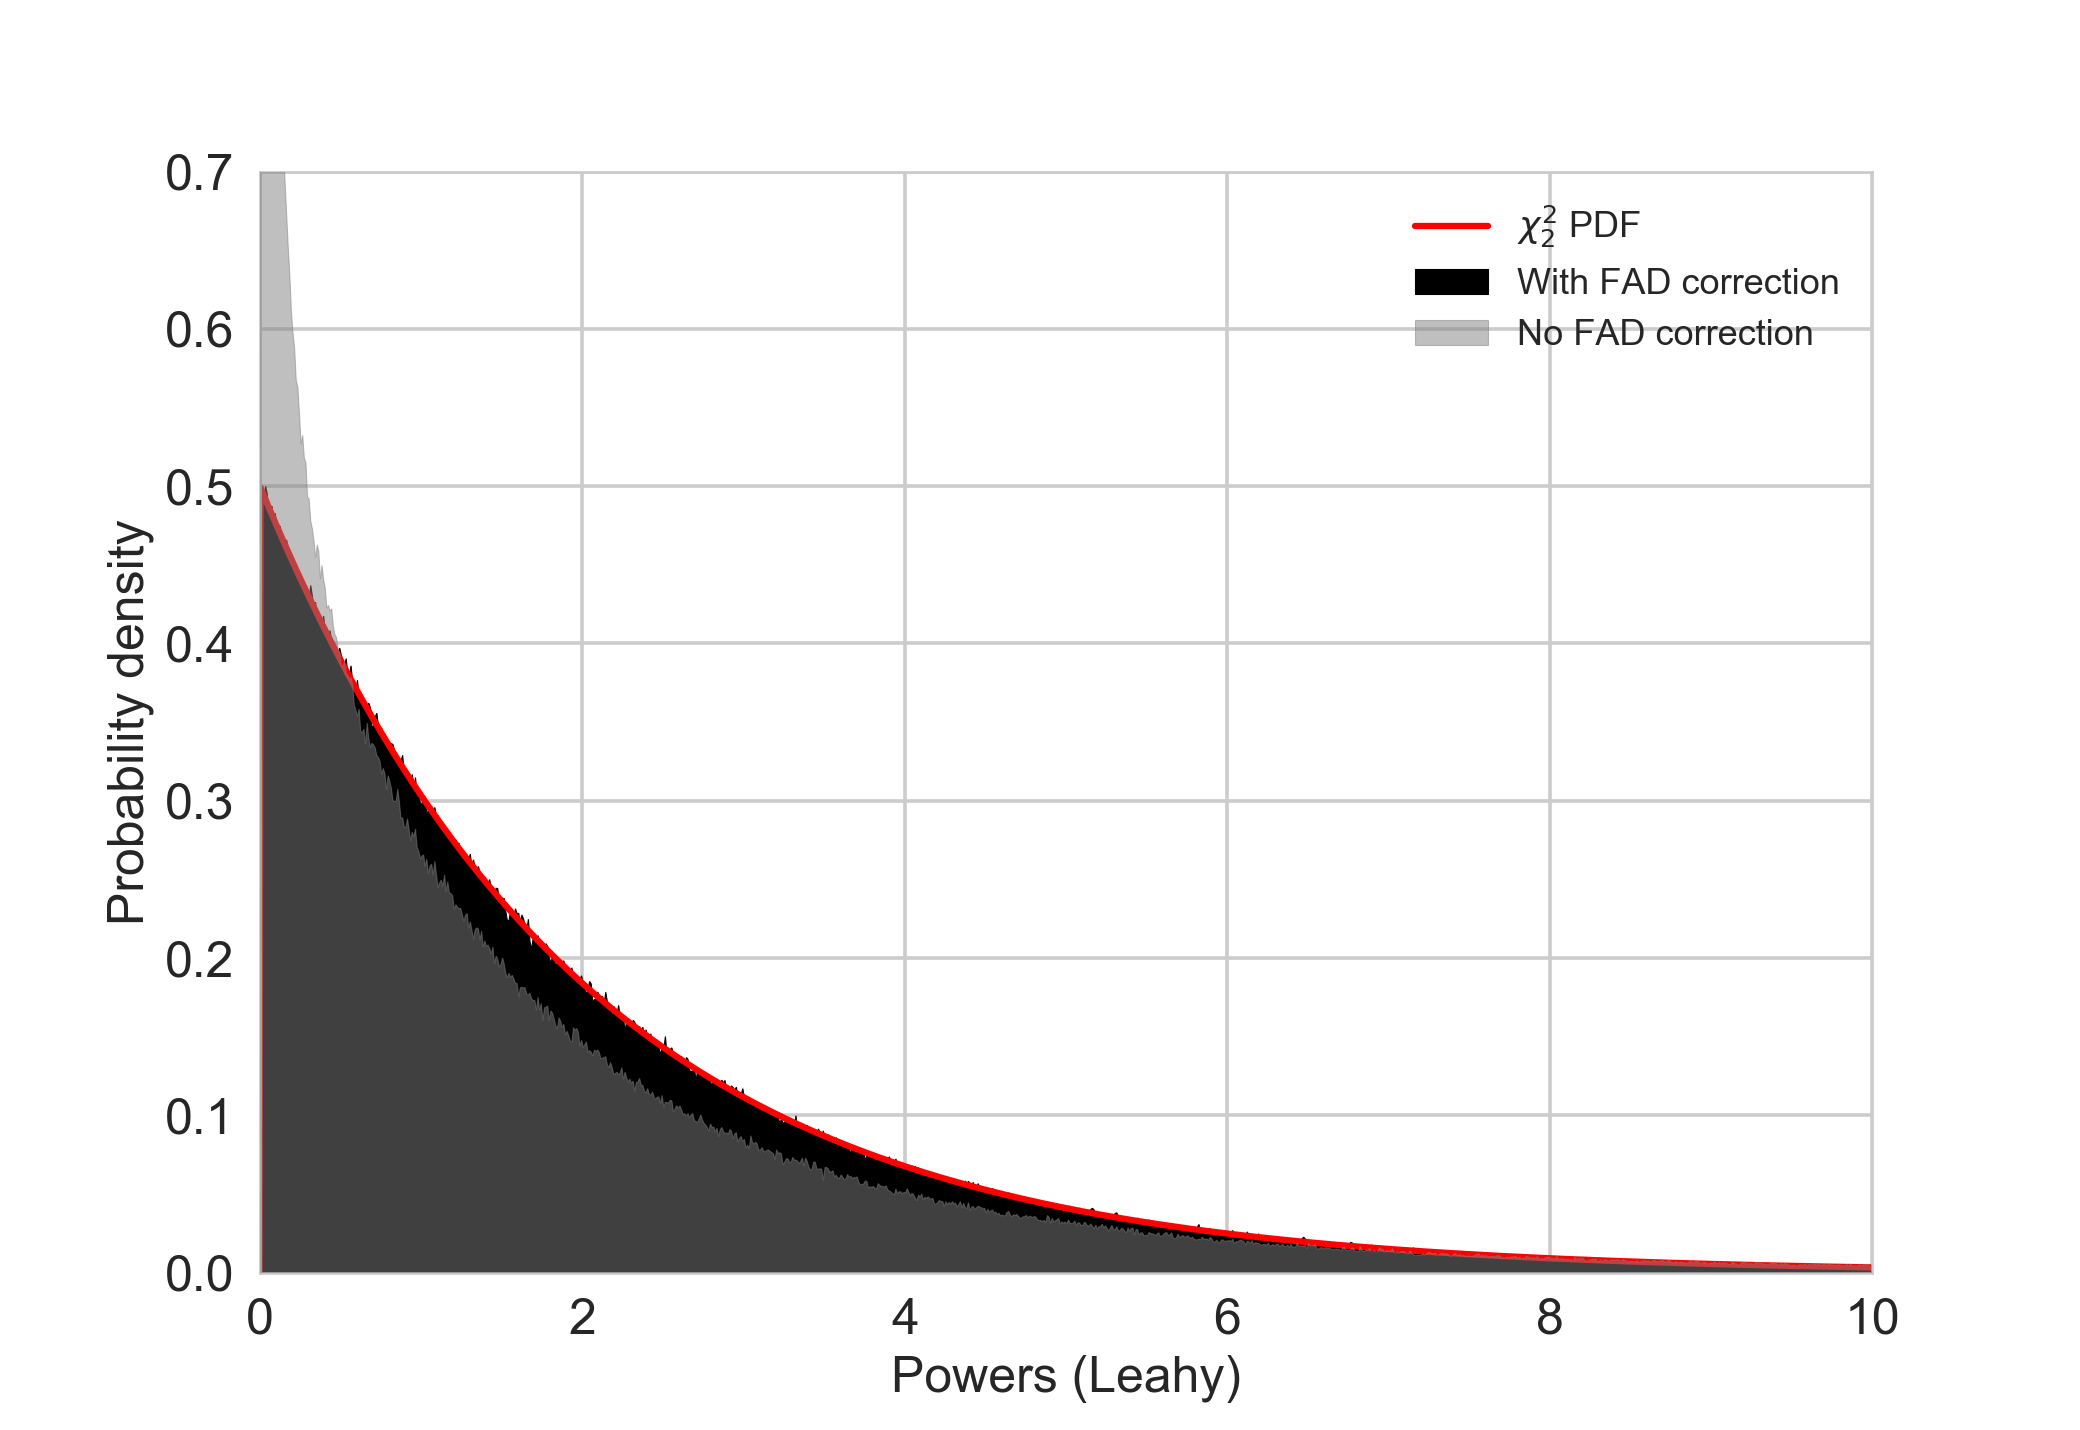

In [13]:
u = np.linspace(-50, 50, 10000)

lapl = scipy.stats.laplace(0, 1)
lapl_prob = lapl.pdf(u)

plt.figure()
plt.fill(bins_cosp[:-1] + 0.005, hist_cosp, label='With FAD correction', color='k')
plt.fill(bins_cosp[:-1] + 0.005, hist_cosp_dt, alpha=0.5, label='No FAD correction', color='grey', zorder=3)

plt.plot(u, lapl_prob, label='Laplace PDF', color='r')
plt.xlim([-5, 5])
plt.ylim([0, 0.7])
plt.legend()
plt.xlabel('Powers (Leahy)')
plt.ylabel('Probability density')

plt.savefig('cosp_pdf.eps')

plt.figure()
u = np.linspace(-10, 50, 10000)
chisq = scipy.stats.chi2(2)
chisq_prob = chisq.pdf(u)


plt.fill(bins_pds[:-1] + 0.005, hist_pds, label='With FAD correction', color='k')
plt.fill(bins_pds[:-1] + 0.005, hist_pds_dt, alpha=0.5, label='No FAD correction', color='grey', zorder=3)


plt.plot(u, chisq_prob, label='$\chi^2_2$ PDF', color='r')
plt.xlabel('Powers (Leahy)')
plt.ylabel('Probability density')

plt.legend()
plt.xlim([0, 10])
plt.ylim([0, 0.7])
plt.savefig('pds_pdf.eps')
